<a href="https://colab.research.google.com/github/RitikBansal175/AR-View/blob/master/Weather_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'multiclass-images-for-weather-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1096724%2F1844417%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T104201Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D835c63fa10d1d266a4ac4d5141e4298192938bf25a0b26031e8e5177b3ffd368f672fc771bcf60084af3ca2581f45161d839843438c6dbd5ca3d141d035b43bc0b2af1ad7fad93ded76e6fbaa688a1c5955e6fb6309feb33205d88b389bad3104df9a78a94a6bb16e8feecbef4800fba32c84f6f8e0f3094c355bc755a324bae5149b2105cc40d7318578cd31ec6e7073013bf8cbf1101f62a669f0f9dfa086f826c20399e9334f6370b16c13956b959c1c826296aa7f0a4b023d8dc1012d601d7680223caa9eaa6949d941eb7a2de4b3b6508e36ca716b8555c77944912f6f009583a95dcac68341f6b39e8c5ba9e269277c0fa7f98123788b55d355b30a9a5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 95740914 bytes downloaded
Downloaded and uncompressed: multiclass-images-for-weather-classification
Data source import complete.


#Load and Resize Dataset

In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm


In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Constants
Dataset_DIR = '../input/multiclass-images-for-weather-classification/dataset2/'
Total_count = 1125

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

# Process images
low_res_images = []
for pic_file in tqdm(os.listdir(Dataset_DIR)[:Total_count]):
    pic = Image.open(os.path.join(Dataset_DIR, pic_file)).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.Resampling.LANCZOS)
    img_array = np.array(pic)
    if img_array.shape == (HEIGHT, WIDTH, 3):  # Check for correct shape
        low_res_images.append(img_array)

#Print length of the updated images after removing corrupted images
print (len(low_res_images))

# Convert list to numpy array and normalize pixel values to [0, 1]
low_res_images = np.array(low_res_images, dtype=np.float32) / 255.0

# Print the shape of the resulting array
print(low_res_images.shape)  # Prints the shape of the normalized image array


100%|██████████| 1125/1125 [00:08<00:00, 133.30it/s]

1120
(1120, 128, 128, 3)


#Building the Generator and Discriminator Models

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
LATENT_DIMENSIONS = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIMENSIONS, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    for _ in range(3):
      x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    for _ in range(4):
      x = Conv2D(256, 4, strides=2)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    # Define optimizer
    optimizer = Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999
    )

    # Compile the discriminator
    discriminator.compile(
        optimizer=optimizer,
        loss=BinaryCrossentropy(from_logits=False)
    )

    return discriminator

#Model Instantiation and Visualization


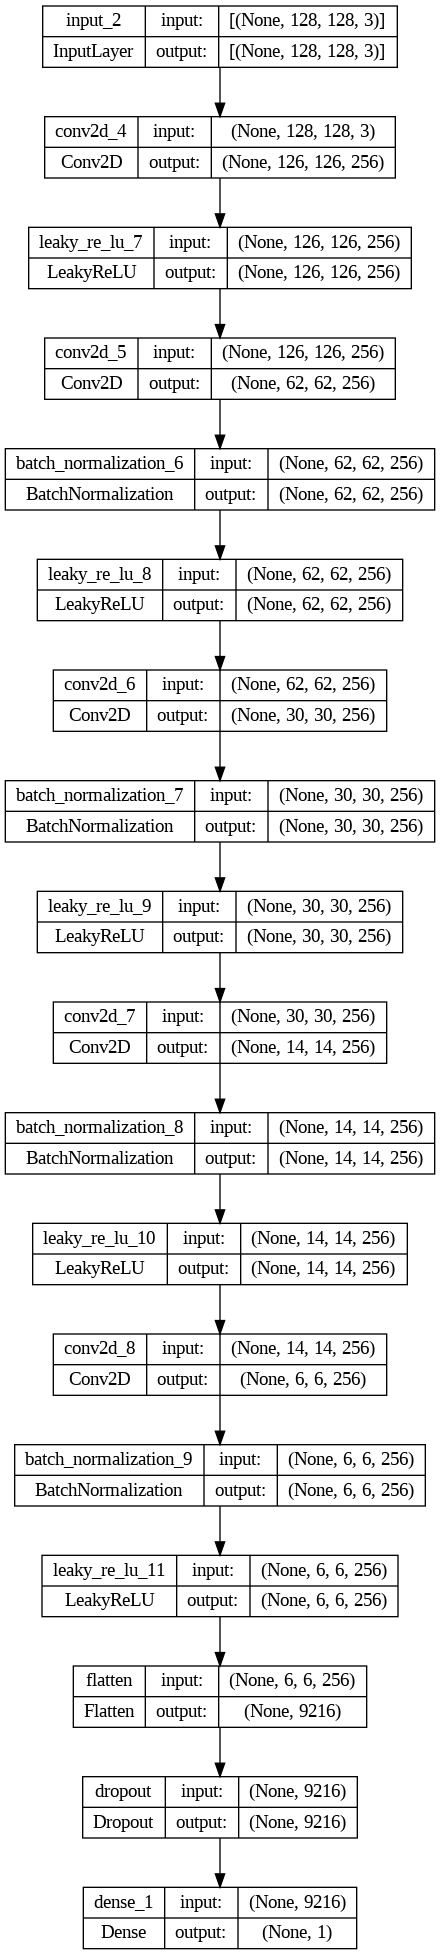

In [ ]:
generator = create_generator()
#generator.summary()

discriminator = create_discriminator()
discriminator.trainable = False
#discriminator.summary()

#Create Gan

gen_input = Input(shape=(LATENT_DIMENSIONS, ))
gen_output = generator(gen_input)
disc_output = discriminator(gen_output)
gan = Model(inputs=gen_input, outputs= disc_output)

# Define optimizer
optimizer = Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999
    )

# Compile the GAN
gan.compile(
    optimizer= optimizer,
    loss=BinaryCrossentropy(from_logits=False)
)

# Visualize the Generator architecture
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True) #Save PNG images
Image(filename='generator.png') # Display PNG image in notebook

# Visualize the Discriminator architecture
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True) #Save PNG images
Image(filename='discriminator.png') # Display PNG image in notebook

In [ ]:
import time
import os
import numpy as np
from PIL import Image as Img
from tensorflow.keras.models import load_model

# Constants
iters = 20
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = os.path.join(RES_DIR, 'generated_%d.png')
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIMENSIONS)) / 2


# running a check if low_res_images is a numpy array of shape (num_images, WIDTH, HEIGHT, CHANNELS)
print(low_res_images.shape)  # Prints the shape of the normalized image array

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    start_time = time.time()

    # Generate fake images
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIMENSIONS))
    generated = generator.predict(latent_vectors, verbose=0)

    # Get a batch of real images
    real = low_res_images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    # Create labels and add noise
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    # Generate misleading targets for the generator training
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIMENSIONS))
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator via the GAN model
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    # Update the start index
    start += batch_size
    if start > low_res_images.shape[0] - batch_size:
        start = 0

    # Save the model and generated images periodically
    if step % 50 == 49:
        gan.save_weights('gan.h5')

        print(f"{step + 1}/{iters}: d_loss: {d_loss:.4f}, a_loss: {a_loss:.4f}. ({time.time() - start_time:.1f} sec)")

        # Generate and save control images
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors, verbose=0)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[y_off * HEIGHT:(y_off + 1) * HEIGHT, x_off * WIDTH:(x_off + 1) * WIDTH, :] = control_generated[i, :, :, :]

        control_image = (control_image * 127.5 + 127.5).astype(np.uint8)
        im = Img.fromarray(control_image.squeeze(), 'L')  # Convert to grayscale if single channel
        im.save(FILE_PATH % images_saved)
        images_saved += 1


(1120, 128, 128, 3)


In [ ]:

# Visualization functions
def plot_losses(d_losses, a_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(a_losses, label='Adversarial Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Adversary Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.show()

def display_generated_images(epoch, generator, control_vectors, example_dim=(6, 6), figsize=(10, 10)):
    generated_images = generator.predict(control_vectors, verbose=0)
    generated_images = 0.5 * generated_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axes = plt.subplots(example_dim[0], example_dim[1], figsize=figsize)
    for i in range(example_dim[0] * example_dim[1]):
        row = i // example_dim[1]
        col = i % example_dim[1]
        ax = axes[row, col]
        ax.imshow(generated_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Plot the losses
plot_losses(d_losses, a_losses)

# Display generated images
display_generated_images(iters, generator, control_vectors)